In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
import math 
import pickle
from pprint import pp
from datetime import datetime

from scipy.stats import linregress, kurtosis, skew
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; } .CodeMirror pre {font-size: 9pt;}</style>"))

In [3]:
devices = ['L', 'R', 'F']
wavelengths = ['740', '850', '940'] # nm
optodes = ['10', '27'] # mm separation from emmitter

t0 = datetime.timestamp(datetime(2023, 4, 1, 0, 0, 0))

In [4]:
pd.options.mode.chained_assignment = None
  
def filter(data, lowcut, highcut):
  fs = 25 # 25 Hz  (40ms intervals)
  order = 6

  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band') 
  y = filtfilt(b, a, data)
  return y

def filter_df(df, lowcut, highcut):
  for dev in devices:
    for opt in optodes:
      df[f'hbo{opt}mm_{dev}_filt'] = filter(df[f'hbo{opt}mm_{dev}'], lowcut, highcut) 
      df[f'hbr{opt}mm_{dev}_filt'] = filter(df[f'hbr{opt}mm_{dev}'], lowcut, highcut)     

In [5]:
def segment_df(df, det, data_dict):
    # pp(opt)
    # pp(df.columns)
    stimuli = ['visual', 'auditory', 'mental']
    for stim in stimuli:
      # create df for each period in parts 1-3 (regular timing) and insert into dict
      data_dict[f'{stim}_regular_math'] = []
      data_dict[f'{stim}_regular_rest'] = []
      for offset in range(0, det['regular_part_time'], 2*det['period_time']):
        math_start = det[f'{stim}_regular_start'] + offset - 5
        math_end = det[f'{stim}_regular_start'] + offset + det['period_time'] + 5
        math_df = df[ (df['timestamp'] > math_start) & (df['timestamp'] < math_end) ]
        data_dict[f'{stim}_regular_math'].append(math_df)
        
        rest_start = det[f'{stim}_regular_start'] + offset + det['period_time'] - 5
        rest_end = det[f'{stim}_regular_start'] + offset + 2*det['period_time'] + 5
        rest_df = df[ (df['timestamp'] > rest_start) & (df['timestamp'] < rest_end) ]
        data_dict[f'{stim}_regular_rest'].append(rest_df)

      # create df for each period in parts 4-6 (random timing) and insert into dict
      data_dict[f'{stim}_random_math'] = []
      data_dict[f'{stim}_random_rest'] = []
      for math_offset, rest_offset in zip(det[f'{stim}_random_math_starts'], det[f'{stim}_random_rest_starts']):
        math_start = det[f'{stim}_random_start'] + math_offset - 5
        math_end = det[f'{stim}_random_start'] + math_offset + det['period_time'] + 5
        math_df = df[ (df['timestamp'] > math_start) & (df['timestamp'] < math_end) ]
        data_dict[f'{stim}_random_math'].append(math_df)

        rest_start = det[f'{stim}_random_start'] + rest_offset - 5
        rest_end = det[f'{stim}_random_start'] + rest_offset + det['period_time'] + 5
        rest_df = df[ (df['timestamp'] > rest_start) & (df['timestamp'] < rest_end) ]
        data_dict[f'{stim}_random_rest'].append(rest_df)

       
    # pp(data_dict)



In [6]:
def create_df(subject):
  dfs = []
  for dev in devices:
    dev_df = pd.read_csv(f'./data/{subject}/blueberry/0{dev}.csv')
    dev_df = dev_df[dev_df.timestamp != 'timestamp']   # remove headers (inserted when device reconnects?)
    dev_df = dev_df.apply(pd.to_numeric)   # objects -> float64 & int64

    # dev_df.timestamp -= t0
    dev_df['timestamp'] = dev_df.timestamp.round(3)
    dev_df['datetime'] = dev_df.timestamp.apply(datetime.fromtimestamp)
    dev_df.set_index('datetime', inplace=True)

    dev_df = dev_df[~dev_df.index.duplicated()]
    dev_df = dev_df.add_suffix(f'_{dev}')
    dfs.append(dev_df)

  df = pd.concat(dfs, axis=1)
  df.interpolate(method='index', axis=0, inplace=True)
  df.reset_index(inplace=True)
  df.dropna(inplace=True)

  df['timestamp'] = df.datetime.apply(datetime.timestamp)
  df.drop(df[df.index%3 != 0].index, inplace=True)
  df.reset_index(drop=True, inplace=True)

  return df

In [7]:
def plot_hb(df):
    nopt = len(optodes)
    ndev = len(devices)
    
    fig, ax = plt.subplots(nopt*ndev,2,figsize=(30, nopt*ndev*10))

    row = 0
    for i, dev in enumerate(devices):
        for j, opt in enumerate(optodes):

            ax[row,0].set_title(f'{opt}mm_{dev}')
            ax[row,0].plot(df['timestamp'], df[f'hbo{opt}mm_{dev}'], linewidth=2)
            ax[row,0].plot(df['timestamp'], df[f'hbo{opt}mm_{dev}_filt'], linewidth=2)
            # row += 1
            ax[row,1].plot(df['timestamp'], df[f'hbr{opt}mm_{dev}'], linewidth=2)
            ax[row,1].plot(df['timestamp'], df[f'hbr{opt}mm_{dev}_filt'], linewidth=2)
            row += 1

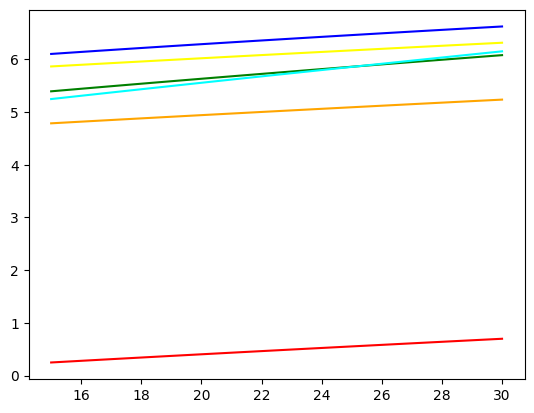

In [8]:
def calc_dpfs(age): 
    dpfs = []
    for wl in wavelengths:
        dpf = 223.3 + (0.05624 * age**0.8493) - (5.723 * 10**-7 * int(wl)**3) + (0.001245 * int(wl)**2) - (0.9025*int(wl))
        dpfs.append(dpf)
    return dpfs

def calc_dpf(age, wl): 
    # equation from [DOI: 10.1117/1.JBO.18.10.105004]
    dpf = 223.3 + (0.05624 * age**0.8493) - (5.723 * 10**-7 * int(wl)**3) + (0.001245 * int(wl)**2) - (0.9025*int(wl))
    return dpf

def dpf_740_john(age):
    return 5.3 + pow(0.049*age, 0.723)

def dpf_850_john(age):
    return 4.5 + pow(0.058*age, 0.823)

def dpf_940_john(age):
    return 4.2 + pow(0.07*age, 0.9)

def dpf(age, wl):
    return 223.3 + (0.05624 * age**0.8493) - (5.723 * 10**-7 * wl**3) + (0.001245 * wl**2) - (0.9025*wl)

x = np.linspace(15,30)
plt.plot(x, dpf_740_john(x), color='blue')
plt.plot(x, dpf_850_john(x), color='green')
plt.plot(x, dpf_940_john(x), color='cyan')

plt.plot(x, dpf(x,740), color='yellow')
plt.plot(x, dpf(x,850), color='orange')
plt.plot(x, dpf(x,940), color='red')

plt.show()

In [ ]:
# #max double 1.7976931348623157E308 / 8192000 (max Int for diffusion) = 2.19444962752e+301 samples

sumTotalHbOShort = 0.0;
sumTotalHbRShort = 0.0;
countTotalShort = 0.0;
sumTotalHbOLong = 0.0;
sumTotalHbRLong = 0.0;
countTotalLong = 0.0;

L1 = 10.3 #// mm
L2 = 27.0 #// mm

# //A = L * absorptionCoeff

# //extinction coefficients
# //https://www.researchgate.net/publication/7910860_Extinction_coefficients_of_hemoglobin_for_near-infrared_spectroscopy_of_tissue
# //Wavelength 1 = 740nm
alphaHbR1 = 1.5
alphaHbO1 = 0.45
# //Wavelength 2 = 850nm
alphaHbR2 = 1.1
alphaHbO2 = 0.75

# //740nm HbR = 1.5    //850nm HbR = 1.1f    //660nm HbR = 1.7f    //880nm HbR = 0.8f     //940nm HbR = 0.9f
# //740nm HbO = 0.45   //850nm HbO = 0.75f   //660nm HbO = 0.35f   //880nm HbO = 1.25f    //940nm HbO = 1.35f

# //DPF value
# //https://www.nature.com/articles/pr19962544/tables/3
age = 31.0

# //volatile float DPF1 = 4.67f;    //880nm
# //volatile float DPF2 = 4.2f;    //940nm
# //volatile float DPF3 = 6.0f;    //~660nm
# //5.3 + pow(0.049 * age, 0.723); //~720nm

DPF1 = 6.65    #//740nm
DPF2 = 6.12    #//850nm

# // 6.650 = 740nm
# // 6.208 = 940nm
# // 6.120 = 850nm

# // 4.5 + pow((0.058*age),0.823);    //850nm
# // 4.67 + pow(0.062*age, 0.819);    //~880nm
# // 4.2 + pow((0.07*age),0.9);       //940nm
# // 6.0 + pow(0.03 * age, 0.65);     //~660nm
# // 5.3 + pow(0.049 * age, 0.723); //~720nm

# //    deltaOD1 = log(Ib / It)
# //    deltaOD1 = log(longIR / shortIR)
# //    Ib = baseline light
# //    It = transient light

def changeHbO(PD1_IR1, PD2_IR1, PD1_IR2, PD2_IR2):

    deltaOD1 = np.log2(float(PD2_IR1) / float(PD1_IR1))
    deltaOD2 = np.log2(float(PD2_IR2) / float(PD1_IR2))

    changeHbOVal = (-1)*(alphaHbR1 * (deltaOD2 / float(DPF2)) - alphaHbO1 * (deltaOD1 / float(DPF1))) / (L2*(alphaHbR2 * alphaHbO1 - alphaHbR2 * alphaHbO2))
    return changeHbOVal


def changeHbR(PD1_IR1, PD2_IR1, PD1_IR2, PD2_IR2):

    deltaOD1 = np.log(float(PD2_IR1) / float(PD1_IR1))
    deltaOD2 = np.log(float(PD2_IR2) / float(PD1_IR2))

    changeHbRVal = (alphaHbO1 * (deltaOD2 /  float(DPF2)) - alphaHbO2 * (deltaOD1 / float(DPF1))) / (L2*(alphaHbR2 * alphaHbO1 - alphaHbR2 * alphaHbO2))
    return changeHbRVal


def changeHbOHbR(diff_hbr_wl:float, diff_hbo_wl:float, distance:float,  path:int)

    # https://mail.nmr.mgh.harvard.edu/pipermail//homer-users/2006-July/000124.html
    # // https://metabolight.org/wp-content/uploads/2018/02/2014-Scholkmann-et-al.-A-review-on-continuous-wave-functional-near-infrared-spectroscopy-and-imaging-instrumentation-and-methodology.pdf

    #        dOD_w1 = -log(I_w1/mean(I_w1));
    #        dOD_w2 = -log(I_w2/mean(I_w2));

    # //        E = GetExtinctions([850 740]);
    # //        E=E(1:2,1:2);
    # //
    # //        dOD_w1_L = dOD_w1 * ppf/(dpf*L);
    # //        dOD_w2_L = dOD_w2 * ppf/(dpf*L);
    # //
    # //        dOD_L = [dOD_w1_L dOD_w2_L];
    # //
    # //        Einv = inv(E'*E)*E';
    # //
    # //        HbO_HbR = Einv * dOD_L';
    # //
    # //        HbO = HbO_HbR(1,:);
    # //        HbR = HbO_HbR(2,:);
    # //
    # //PD - Photodiode wavelength (e.g 740, 850, 940)
    # //IR - IR Distance - (e.g. 10, 27)

    L1 = distance #// mm

    # //A = L * absorptionCoeff
    # //extinction coefficients
    # //https://www.researchgate.net/publication/7910860_Extinction_coefficients_of_hemoglobin_for_near-infrared_spectroscopy_of_tissue

    # //Wavelength 1 = 740nm
    alphaHbO_WL740 = 0.45

    # //Wavelength 1 = 740nm
    alphaHbR_WL740 = 1.5

#     //Wavelength 2 = 940nm
# //        let alphaHbO_WL940 = 1.35;

    # Wavelength 2 = 940nm
    # let alphaHbR_WL940 = 0.9;

    # Wavelength 3 = 850nm
    alphaHbR_WL850 = 1.1

    # //Wavelength 3 = 850nm
    alphaHbO_WL850 = 0.75

    # //alt 740nm        //alt 850nm         //alt 660nm           //alt 880nm            //alt 940nm
    # //740 HbR = 1.5    //850 HbR = 1.1f    //660nm HbR = 1.7f    //880nm HbR = 0.8f     //940nm HbR = 0.9f
    # //740 HbO = 0.45   //850 HbO = 0.75f   //660nm HbO = 0.35f   //880nm HbO = 1.25f    //940nm HbO = 1.35f

    # function for determining DPF based on gender and age
    # let age = 31;
    # DPF value
    # https://www.nature.com/articles/pr19962544/tables/3
    DPF1 = 6.65     #//740nm
# //        let DPF2 = 6.208;    //940nm
    DPF3 = 6.12    #//850nm

    ppf = 0.1
    meanhboPD1 = 0.0
    meanhbrPD1 = 0.0
    
    # //based on ratio to get to common 2mW/sr for LED intensity at 20mA
    factor740nm = 3.33
    factor940nm = 1.67
    factor850nm = 1.0
    
    # //based on photodiode used
    # //https://www.mouser.ca/datasheet/2/427/vemd8081-1923765.pdf
    qEfficiency740nm = 0.94
    qEfficiency850nm = 1.0
    
    # //sensitivity area for photodiode, 2x PD on long path
    shortPathSA = 1.0
    longPathSA = 2.0

    if path == 0:
        sumTotalHbOShort = sumTotalHbOShort + (diff_hbo_wl * (factor850nm/qEfficiency850nm))/shortPathSA
        sumTotalHbRShort = sumTotalHbRShort + (diff_hbr_wl * (factor740nm/qEfficiency740nm))/shortPathSA
        countTotalShort = countTotalShort + 1.0
        meanhboPD1 = sumTotalHbOShort / countTotalShort # // hbo, > 800nm
        meanhbrPD1 = sumTotalHbRShort / countTotalShort # // hbr, < 800nm
    elif path == 1:
        sumTotalHbOLong = sumTotalHbOLong + (diff_hbo_wl * (factor850nm/qEfficiency850nm))/longPathSA
        sumTotalHbRLong = sumTotalHbRLong + (diff_hbr_wl * (factor740nm/qEfficiency740nm))/longPathSA
        countTotalLong = countTotalLong + 1.0
        meanhboPD1 = sumTotalHbOLong / countTotalLong # // hbo, > 800nm
        meanhbrPD1 = sumTotalHbRLong / countTotalLong # // hbr, < 800nm


    E: [Double] = [
        [alphaHbO_WL850, alphaHbR_WL850],
        [alphaHbO_WL740, alphaHbR_WL740]
    ].flatMap { $0 }
    
    # //creates log(n) curve with iterative mean
    dOD_hbo_WL = 0.0
    dOD_hbr_WL = 0.0
    
    if path == 0:
        dOD_hbo_WL = -1 * np.log( abs( diff_hbo_wl* (factor850nm/qEfficiency850nm) /shortPathSA) /meanhboPD1)
        dOD_hbr_WL = -1 * np.log( abs( diff_hbr_wl* (factor740nm/qEfficiency740nm) /shortPathSA) /meanhbrPD1)
    elif path == 1:
        dOD_hbo_WL = -1 * np.log( abs( diff_hbo_wl* (factor850nm/qEfficiency850nm) /longPathSA) /meanhboPD1)
        dOD_hbr_WL = -1 * np.log( abs( diff_hbr_wl* (factor740nm/qEfficiency740nm) /longPathSA) /meanhbrPD1)


    dOD_hbo_L1 = dOD_hbo_WL * ppf / (DPF1 * L1)
    dOD_hbr_L1 = dOD_hbr_WL * ppf / (DPF3 * L1)

    dOD_L: [Double] = [
        [dOD_hbo_L1, dOD_hbr_L1],
        [0.0, 0.0]
    ].flatMap { $0 }

    # //Einv = inv(E'*E)*E';
    Et = transpose2x2(E)
    EtxE = vDSP.multiply(E, Et)
    invEtxE = invert2x2(EtxE)
    Einv = vDSP.multiply(invEtxE,E)
# //        print(Einv)

    # //HbO_HbR = Einv * dOD_L']
    hboHbr = [0.0,0.0]

    t_dOD_L = transpose2x1(dOD_L)
# //        print(t_dOD_L)
    HbOHbR = multiply2x2by2x1(Einv, b: t_dOD_L)
# //        print(HbOHbR)
    output = HbOHbR
    hbo = output[0]
    hbr = output[1]

    hboHbr[0] = hbo
    hboHbr[1] = hbr

    return hboHbr

def shortChannelCorrectionSingle(data10mm, data27mm):

    # //https://github.com/mne-tools/mne-nirs/blob/a0e7cd25f1e829826b3a9f3c3f4823dd947b5dae/mne_nirs/signal_enhancement/_short_channel_correction.py
    # //        # Eqn 27 Scholkmann et al 2014
    # //        alfa = np.dot(A_s, A_l) / np.dot(A_s, A_s)
    # //
    # //        # Eqn 26 Scholkmann et al 2014
    # //        correctedVal = A_l - alfa * A_s

    factor = 1.000000001 # //scales adjustment

    A_l = data27mm
    A_s = data10mm
    alfa = ((A_l * A_s) / (A_s * A_s))*factor
    correctionVal = (A_l*factor) - (alfa * (A_s*factor))    # //scale single values by factor
    correctionVal = correctionVal/factor                    # //reverse factor scaling

    return correctionVal

def calc_dpfs_john(age):
    dpf740 = 5.3 + pow(0.049*age, 0.723)
    dpf850 = 4.5 + pow(0.058*age, 0.823)
    dpf940 = 4.2 + pow(0.07*age, 0.9)
    return [dpf740, dpf850, dpf940]


In [37]:


def estimate_hb(df, age):
    l1 = 10.3
    l2 = 27.0

    hbo740 = 0.45
    hbr740 = 1.5

    hbo850 = 0.75
    hbr850 = 1.1

    hbo940 = 1.35
    hbr940 = 0.9

    # extinction coefficients (https://omlc.org/spectra/hemoglobin/summary.html)
    e_hbo_740 = 0.446
    e_hbr_740 = 1.11588

    e_hbo_850 = 1.058
    e_hbr_850 = 0.69132

    e_hbo_940 = 1.214
    e_hbr_940 = 0.69344

    # oxy_740 = 0.065
    # dxy_740 = 0.175

    # oxy_850 = 0.115 
    # dxy_850 = 0.1  
    
    # oxy_940 = 0.14  
    # dxy_940 = 0.075 

    E = np.array([[e_hbo_740, e_hbr_740],
                  [e_hbo_850, e_hbr_850],
                  [e_hbo_940, e_hbr_940]])

    for dev in devices:
        for opt in optodes:
            B = []
            dODs = []
            dpfs  = []
            for wl in wavelengths:
                I = df[f'{wl}nm{opt}mm_{dev}'].values / df[f'{wl}nm{opt}mm_{dev}'].mean() # normalized light intensity 
                dODs.append( -np.log10(I) ) # change in optical density  LN?
                dpfs.append( calc_dpf(int(wl), age) )

            print(dODs)
            print(dpfs)

            #     B.append(dOD/dpf)
            # B = np.array(B)
            # print(B)

            dC = 1/int(opt) * (E * dpfs) * np.dot(np.linalg.inv(A), B) # change in concentrations
            # df[f'hbo{opt}mm_{dev}'] = dC[0]
            # df[f'hbr{opt}mm_{dev}'] = dC[1]

In [38]:

data_dict = {}
subjects = ['khiem']#,'zoey','daniel', 'david', 'nader']
for subject in subjects:
  file = open(f'./data/{subject}/blueberry/0timing.pkl', 'rb')
  details = pickle.load(file)

  df = create_df(subject)
  display(df)
  
  estimate_hb(df, 21)
  filter_df(df, 0.01, 0.5)

  print(df.columns)
  plot_hb(df)

  # df.plot(kind='line',y=['timestamp','timestamp_R','timestamp_L','timestamp_F'])
  # df.plot(kind='line',y=['ms_device_R','ms_device_L','ms_device_F'])
  # display(df)


  # display(df)
  # ylim = [0, df.timestamp.max]
  # xlim = [0, len(df.timestamp.values)]
  # print(df.timestamp)
  # print(xlim, ylim)

  # df.plot(kind='bar', y=['timestamp_L','timestamp_R','timestamp_F'])#, xlim = [0,len(df['timestamp'].values)], ylim=[0,df['timestamp'].max])
  # data.plot(df.timestamp_R)
  # data.plot(df.timestamp_F)
  # plt.show()
  # display(df.iloc[:, 27:])
  # print(df.columns)
  # display(df[['hbo']])
  # plot_data(df)
  # segment_df(df, details, data_dict)
  

  # df.timestamp -= rec_start_times[i] #df.timestamp.values[0]

  # recs.append(df)

,datetime,timestamp_L,ms_device_L,ambient_L,740nm10mm_L,940nm10mm_L,850nm10mm_L,740nm27mm_L,940nm27mm_L,850nm27mm_L,...,timestamp_F,ms_device_F,ambient_F,740nm10mm_F,940nm10mm_F,850nm10mm_F,740nm27mm_F,940nm27mm_F,850nm27mm_F,timestamp
0,2023-04-16 13:32:40.593,1.681666e+09,450520.000000,4.612775e+06,164913.000000,198297.000000,222976.000000,4.659649e+06,4.686111e+06,4.698328e+06,...,1.681666e+09,2.694010e+05,54152.423693,434438.924045,543066.173261,1.929341e+06,237087.399590,211146.272870,577407.672333,1.681666e+09
1,2023-04-16 13:32:40.633,1.681666e+09,450560.000000,4.632128e+06,164826.000000,198599.000000,223067.000000,4.649664e+06,4.674490e+06,4.680783e+06,...,1.681666e+09,2.694410e+05,54944.513115,435017.615607,544140.588786,1.932008e+06,237351.281114,212439.359279,579092.226881,1.681666e+09
2,2023-04-16 13:32:40.673,1.681666e+09,450600.000000,4.632734e+06,164427.000000,198299.000000,223210.000000,4.650278e+06,4.674015e+06,4.681237e+06,...,1.681666e+09,2.694820e+05,54758.101018,434929.947379,544745.246784,1.936190e+06,237920.148326,212263.699955,581447.593306,1.681666e+09
3,2023-04-16 13:32:40.711,1.681666e+09,450640.999936,4.634388e+06,164734.174861,198606.675021,223206.924685,4.651155e+06,4.674728e+06,4.680224e+06,...,1.681666e+09,2.695200e+05,54456.000000,435708.000000,545700.000000,1.939104e+06,238417.000000,212277.000000,583435.000000,1.681666e+09
4,2023-04-16 13:32:40.751,1.681666e+09,450680.999936,4.660637e+06,164813.200371,198600.574579,223398.200051,4.652657e+06,4.665448e+06,4.668272e+06,...,1.681666e+09,2.695600e+05,60777.000000,435917.000000,546497.000000,1.941788e+06,238609.000000,213380.000000,585416.000000,1.681666e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141648,2023-04-16 17:16:37.006,1.681680e+09,617857.000192,4.666328e+06,159525.075283,165596.974266,159370.725754,4.691612e+06,4.641642e+06,4.683418e+06,...,1.681672e+09,5.766080e+06,195037.000000,446171.000000,577520.000000,2.074341e+06,345476.000000,344873.000000,644738.000000,1.681680e+09
141649,2023-04-16 17:16:37.085,1.681680e+09,617912.941176,4.604695e+06,159615.000000,165630.058824,159403.352941,4.637091e+06,4.688389e+06,4.618835e+06,...,1.681672e+09,5.766080e+06,195037.000000,446171.000000,577520.000000,2.074341e+06,345476.000000,344873.000000,644738.000000,1.681680e+09
141650,2023-04-16 17:16:37.137,1.681680e+09,617960.000000,4.596098e+06,159517.000000,165636.000000,159470.000000,4.653381e+06,4.672282e+06,4.611079e+06,...,1.681672e+09,5.766080e+06,195037.000000,446171.000000,577520.000000,2.074341e+06,345476.000000,344873.000000,644738.000000,1.681680e+09
141651,2023-04-16 17:16:37.176,1.681680e+09,618002.222096,4.598600e+06,159545.277193,165681.055211,159390.889237,4.648655e+06,4.677454e+06,4.611131e+06,...,1.681672e+09,5.766080e+06,195037.000000,446171.000000,577520.000000,2.074341e+06,345476.000000,344873.000000,644738.000000,1.681680e+09


A:  [[0.065 0.175]
 [0.115 0.1  ]
 [0.14  0.075]]


LinAlgError: Last 2 dimensions of the array must be square